<img src="idal-logo.png" align="right" style="float" width="400">
<font color="#CA3532"><h1 align="left">Máster Inteligencia Artificial Avanzada y Aplicada</h1></font>
<font color="#6E6E6E"><h2 align="left">Impacto del Análisis de Sentimientos en la Predicción de Precios Financieros</h2></font> 
<font color="#6E6E6E"><h2 align="left">Comparativa entre LSTM, BERT y FinBERT</h2></font>

#### Francisco de Borja Gregori Garcia


# CÓDIGO

#### [Apartado 1: Librerias y Configuración Inicial](#apartado-1)

#### [Apartado 2: Obtención de Datos Financieros y de Noticias](#apartado-2)

#### [Apartado 3: Preprocesamiento y Limpieza de Datos](#apartado-3)

#### [Apartado 4: Análisis de Sentimientos](#apartado-4)

#### [Apartado 5: Complementos](#apartado-5)

#### [Apartado 6: Modelos Predictivos](#apartado-6)

#### [Apartado 7: Evaluación y Visualización de Resultados](#apartado-7)

#### [Apartado 8: Resultados](#apartado-8)

<a id="apartado-1"></a>
### Apartado 1: Librerias y Configuración Inicial

In [1]:
# ------------------------------------------------
# Librerías y configuraciones iniciales
# ------------------------------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Obtención de datos
import time
import yfinance as yf
import requests
import logging
from datetime import datetime, timedelta

# Limpieza y procesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')

# Preprocesamiento y métricas
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

logging.basicConfig(level=logging.INFO)

API_KEY = 'csur32pr01qgo8nia6dgcsur32pr01qgo8nia6e0'
SYMBOL = 'AAPL'
START_DATE = '2024-03-31'
END_DATE = '2025-03-25'
LOOK_BACK = 7

<a id="apartado-2"></a>
### Apartado 2: Obtención de Datos Financieros y de Noticias

In [2]:
# ------------------------------------------------
# Funciones para obtención de datos
# ------------------------------------------------
def historical_data(symbol, start_date, end_date):
    # Inicia el proceso de obtención de precios históricos para el símbolo y rango de fechas especificado
    logging.info(f"Buscando precios de {symbol} desde {start_date} hasta {end_date}...")
    try:
        # Descarga los datos históricos utilizando yfinance
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        stock_data.reset_index(inplace=True)
    except Exception as e:
        logging.error(f"Error al descargar datos para {symbol}: {e}")
        return pd.DataFrame()
    
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    stock_data['NSI'] = nsi(stock_data)
    
    # Define el nombre del archivo para guardar los datos históricos
    filename = f"{symbol}_historical_data.csv"
    try:
        logging.info(f"Guardando {filename}...")
        stock_data.to_csv(filename, index=False)
        logging.info(f"Guardado correctamente {filename}.")
    except Exception as e:
        logging.error(f"Error al guardar {filename}: {e}")
    
    return stock_data

def news_data(symbol, start_date, end_date, api_key):
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    all_news = []
    call_count = 0

    # Define palabras clave relacionadas con Apple para filtrar noticias relevantes
    apple_keywords = ['Apple', 'iPhone', 'Mac', 'iPad', 'Tim Cook', 'iOS', 'macOS', 'Apple Watch', 'AirPods']

    # Bucle que itera sobre cada día en el rango especificado
    while current_date <= end_date_dt:
        date_str = current_date.strftime("%Y-%m-%d")
        logging.info(f"Buscando noticias para {symbol} en {date_str}...")

        # Define la URL y los parámetros de la solicitud a la API
        url = 'https://finnhub.io/api/v1/company-news'
        params = {'symbol': symbol, 'from': date_str, 'to': date_str, 'token': api_key}

        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            for item in data:
                headline = item.get('headline', '')
                # Filtra las noticias que contienen alguna de las palabras clave definidas
                if any(keyword.lower() in headline.lower() for keyword in apple_keywords):
                    news_item = {
                        'datetime': datetime.fromtimestamp(item['datetime']).date(),
                        'headline': headline}
                    all_news.append(news_item)
        except Exception as e:
            logging.error(f"Error buscando noticias para {symbol} en {date_str}: {e}")

        call_count += 1
        # Si se alcanza el límite de llamadas, espera 60 segundos para evitar bloqueos
        if call_count >= 55:
            logging.info("Límite de llamadas a la API alcanzado. Esperando 60 segundos...")
            time.sleep(60)
            call_count = 0
        current_date += timedelta(days=1)

    news_df = pd.DataFrame(all_news)
    # Define el nombre del archivo para guardar los datos de noticias
    filename = f"{symbol}_news_data.csv"
    try:
        logging.info(f"Guardando {filename}...")
        news_df.to_csv(filename, index=False)
        logging.info(f"Guardado correctamente {filename}.")
    except Exception as e:
        logging.error(f"Error al guardar {filename}: {e}")

    return news_df

<a id="apartado-3"></a>
### Apartado 3: Preprocesamiento y Limpieza de Datos

In [3]:
# ------------------------------------------------
# Función fusionada para limpieza y procesamiento de texto
# ------------------------------------------------
def process_text(text):
    if not isinstance(text, str):
        return ""
    
    # Eliminar URLs y etiquetas HTML
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # Eliminar espacios extra y recortar
    text = re.sub(r'\s+', ' ', text).strip()
    # Convertir a minúsculas
    text = text.lower()
    # Filtrar caracteres: se permiten letras, números, espacios y algunos caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s%$#@]', '', text)
    # Tokenización
    words = text.split()
    # Eliminar stopwords, conservando "not" y "never"
    stop_words = set(stopwords.words('english')) - {'not', 'never'}
    words = [word for word in words if word not in stop_words]
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

<a id="apartado-4"></a>
### Apartado 4: Análisis de Sentimientos

In [4]:
# ------------------------------------------------
# Función auxiliar para cálculo de sentimiento
# ------------------------------------------------
def sentiment_score(result):
    if isinstance(result, list):
        result = result[0]
    label = result.get('label', '').upper()
    score = result.get('score', 0)
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -score
    else:
        return 0

# ------------------------------------------------
# Análisis de sentimientos con BERT
# ------------------------------------------------
def analyze_sentiment_bert(news_df):
    logging.info("Analizando sentimientos con BERT...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    
    # Preprocesamiento de solo titulares
    news_df['cleaned_headline'] = news_df['headline'].apply(process_text)

    # Analizar titulares
    headlines = news_df['cleaned_headline'].tolist()
    headlines_results = sentiment_analyzer(headlines, truncation=True)
    news_df['headline_sentiment'] = [sentiment_score(res) for res in headlines_results]

    daily_sentiments = news_df.groupby('datetime')['headline_sentiment'].mean().reset_index()
    logging.info("Análisis de sentimientos con BERT completado.")
    return daily_sentiments

# ------------------------------------------------
# Análisis de sentimientos con FinBERT
# ------------------------------------------------
def analyze_sentiment_finbert(news_df):
    logging.info("Analizando sentimientos con FinBERT...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="ProsusAI/finbert")
    
    # Preprocesamiento de solo titulares
    news_df['cleaned_headline'] = news_df['headline'].apply(process_text)

    # Analizar titulares
    headlines = news_df['cleaned_headline'].tolist()
    headlines_results = sentiment_analyzer(headlines, truncation=True)
    news_df['headline_sentiment_finbert'] = [sentiment_score(res) for res in headlines_results]

    daily_sentiments_finbert = news_df.groupby('datetime')['headline_sentiment_finbert'].mean().reset_index()
    logging.info("Análisis de sentimientos con FinBERT completado.")
    return daily_sentiments_finbert

<a id="apartado-5"></a>
### Apartado 5: Complementos

In [5]:
# ------------------------------------------------
# Definición de la capa de atención personalizada
# ------------------------------------------------
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# ------------------------------------------------
# Función para calcular NSI (Numerical Sentiment Index)
# ------------------------------------------------
def nsi(data: pd.DataFrame, s: float = 0.01, k: int = 1) -> pd.Series:
    ret = (data['Close'].shift(-k) - data['Open']) / data['Open']
    nsi = np.where(ret > s, 1, np.where(ret < -s, -1, 0))
    return pd.Series(nsi.ravel(), index=ret.index)

# ------------------------------------------------
# Funciones de ayuda para series de tiempo
# ------------------------------------------------
def lstm_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


<a id="apartado-6"></a>
### Apartado 6: Modelos Predictivos

In [6]:
# ------------------------------------------------
# Modelos LSTM con capa de atención
# ------------------------------------------------
def train_lstm(stock_data, look_back):
    # Escalar la característica: Close
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Close']])
    
    # Preparar los datos en formato adecuado para LSTM
    X, y = lstm_data(scaled_data, look_back)
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Arquitectura del modelo
    model_price = Sequential([
        Input(shape=(look_back, 1)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.2),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.2),
        AttentionLayer(),
        Dense(64, activation='relu'),
        Dense(1)])
    model_price.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    logging.info("Entrenando modelo LSTM (solo precios)...")
    history = model_price.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping, reduce_lr])
    
    return model_price, scaler, X_val, y_val, X_test, y_test, history

def train_lstm_bert(stock_data, news_sentiments_bert, look_back):
    # Mapear el sentimiento diario al stock_data
    stock_data['Sentiment_BERT'] = stock_data['Date'].map(
        news_sentiments_bert.set_index('datetime')['headline_sentiment'])
    # Rellenar NaN con 0
    stock_data.fillna(0, inplace=True)
    
    # Escalar las tres características: Close, Sentiment_BERT y NSI
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Close', 'Sentiment_BERT', 'NSI']])
    
    # Preparar los datos en formato adecuado para LSTM
    X, y = lstm_data(scaled_data, look_back)
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Arquitectura del modelo
    model_bert = Sequential([
        Input(shape=(look_back, 3)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        AttentionLayer(),
        Dense(64, activation='relu'),
        Dense(1)])
    model_bert.compile(optimizer=Adam(learning_rate=0.0017), loss='mean_squared_error')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    logging.info("Entrenando modelo LSTM + BERT...")
    history_bert = model_bert.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=64,
        verbose=1,
        callbacks=[reduce_lr])
    
    return model_bert, scaler, X_val, y_val, X_test, y_test, history_bert

def train_lstm_finbert(stock_data, news_sentiments_finbert, look_back):
    # Mapear el sentimiento diario al stock_data
    stock_data['Sentiment_FinBERT'] = stock_data['Date'].map(
        news_sentiments_finbert.set_index('datetime')['headline_sentiment_finbert'])
    # Rellenar NaN con 0
    stock_data.fillna(0, inplace=True)
    
    # Escalar las tres características: Close, Sentiment_FinBERT y NSI
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Close', 'Sentiment_FinBERT', 'NSI']])
    
    # Preparar los datos en formato adecuado para LSTM
    X, y = lstm_data(scaled_data, look_back)
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Arquitectura del modelo
    model_finbert = Sequential([
        Input(shape=(look_back, 3)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        AttentionLayer(),
        Dense(64, activation='relu'),
        Dense(1)])
    model_finbert.compile(optimizer=Adam(learning_rate=0.0017), loss='mean_squared_error')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    logging.info("Entrenando modelo LSTM + FinBERT...")
    history_finbert = model_finbert.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=64,
        verbose=1,
        callbacks=[reduce_lr])
    
    return model_finbert, scaler, X_val, y_val, X_test, y_test, history_finbert

<a id="apartado-7"></a>
### Apartado 7: Evaluación y Visualización de Resultados

In [7]:
# ------------------------------------------------
# Métricas adicionales
# ------------------------------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ------------------------------------------------
# Visualización y reporte de métricas
# ------------------------------------------------
def plot_predictions(models, scalers, datasets, stock_data):
    model_price, model_bert, model_finbert = models
    scaler_price, scaler_bert, scaler_finbert = scalers
    (X_val_price, y_val_price, X_test_price, y_test_price), \
    (X_val_bert, y_val_bert, X_test_bert, y_test_bert), \
    (X_val_finbert, y_val_finbert, X_test_finbert, y_test_finbert) = datasets

    # Predicciones
    price_predictions_val = model_price.predict(X_val_price).flatten()
    price_predictions_test = model_price.predict(X_test_price).flatten()
    bert_predictions_val = model_bert.predict(X_val_bert).flatten()
    bert_predictions_test = model_bert.predict(X_test_bert).flatten()
    finbert_predictions_val = model_finbert.predict(X_val_finbert).flatten()
    finbert_predictions_test = model_finbert.predict(X_test_finbert).flatten()

    # Desnormalización
    y_val_price_unscaled = scaler_price.inverse_transform(np.array(y_val_price).reshape(-1,1))[:, 0]
    y_test_price_unscaled = scaler_price.inverse_transform(np.array(y_test_price).reshape(-1,1))[:, 0]
    price_predictions_val_unscaled = scaler_price.inverse_transform(np.array(price_predictions_val).reshape(-1,1))[:, 0]
    price_predictions_test_unscaled = scaler_price.inverse_transform(np.array(price_predictions_test).reshape(-1,1))[:, 0]

    y_val_bert_unscaled = scaler_bert.inverse_transform(np.c_[y_val_bert, np.zeros((len(y_val_bert), 2))])[:, 0]
    y_test_bert_unscaled = scaler_bert.inverse_transform(np.c_[y_test_bert, np.zeros((len(y_test_bert), 2))])[:, 0]
    bert_predictions_val_unscaled = scaler_bert.inverse_transform(np.c_[bert_predictions_val, np.zeros((len(bert_predictions_val), 2))])[:, 0]
    bert_predictions_test_unscaled = scaler_bert.inverse_transform(np.c_[bert_predictions_test, np.zeros((len(bert_predictions_test), 2))])[:, 0]

    y_val_finbert_unscaled = scaler_finbert.inverse_transform(np.c_[y_val_finbert, np.zeros((len(y_val_finbert), 2))])[:, 0]
    y_test_finbert_unscaled = scaler_finbert.inverse_transform(np.c_[y_test_finbert, np.zeros((len(y_test_finbert), 2))])[:, 0]
    finbert_predictions_val_unscaled = scaler_finbert.inverse_transform(np.c_[finbert_predictions_val, np.zeros((len(finbert_predictions_val), 2))])[:, 0]
    finbert_predictions_test_unscaled = scaler_finbert.inverse_transform(np.c_[finbert_predictions_test, np.zeros((len(finbert_predictions_test), 2))])[:, 0]

    # Métricas LSTM
    price_rmse_test = np.sqrt(mean_squared_error(y_test_price_unscaled, price_predictions_test_unscaled))
    price_mae_test = mean_absolute_error(y_test_price_unscaled, price_predictions_test_unscaled)
    price_r2_test = r2_score(y_test_price_unscaled, price_predictions_test_unscaled)
    price_mape_test = mape(y_test_price_unscaled, price_predictions_test_unscaled)

    logging.info(f"[LSTM] RMSE={price_rmse_test:.2f}, MAE={price_mae_test:.2f}, R²={price_r2_test:.2f}, "f"MAPE={price_mape_test:.2f}%")

    # Métricas LSTM + BERT
    bert_rmse_test = np.sqrt(mean_squared_error(y_test_bert_unscaled, bert_predictions_test_unscaled))
    bert_mae_test = mean_absolute_error(y_test_bert_unscaled, bert_predictions_test_unscaled)
    bert_r2_test = r2_score(y_test_bert_unscaled, bert_predictions_test_unscaled)
    bert_mape_test = mape(y_test_bert_unscaled, bert_predictions_test_unscaled)

    logging.info(f"[LSTM+BERT] RMSE={bert_rmse_test:.2f}, MAE={bert_mae_test:.2f}, R²={bert_r2_test:.2f}, "f"MAPE={bert_mape_test:.2f}%")

    # Métricas LSTM + FinBERT
    finbert_rmse_test = np.sqrt(mean_squared_error(y_test_finbert_unscaled, finbert_predictions_test_unscaled))
    finbert_mae_test = mean_absolute_error(y_test_finbert_unscaled, finbert_predictions_test_unscaled)
    finbert_r2_test = r2_score(y_test_finbert_unscaled, finbert_predictions_test_unscaled)
    finbert_mape_test = mape(y_test_finbert_unscaled, finbert_predictions_test_unscaled)

    logging.info(f"[LSTM+FinBERT] RMSE={finbert_rmse_test:.2f}, MAE={finbert_mae_test:.2f}, R²={finbert_r2_test:.2f}, "f"MAPE={finbert_mape_test:.2f}%")

    # Gráfico comparativo
    plt.figure(figsize=(14,7))
    dates = stock_data['Date'][-(len(y_val_price)+len(y_test_price)):]
    real_prices = np.concatenate([y_val_price_unscaled, y_test_price_unscaled])

    plt.plot(dates, real_prices, label='Precios Reales', color='blue')
    plt.plot(dates[:len(y_val_price)], price_predictions_val_unscaled, label='LSTM (Validación)', color='green')
    plt.plot(dates[:len(y_val_bert)], bert_predictions_val_unscaled, label='LSTM+BERT (Validación)', color='red')
    plt.plot(dates[:len(y_val_finbert)], finbert_predictions_val_unscaled, label='LSTM+FinBERT (Validación)', color='orange')
    plt.plot(dates[len(y_val_price):], price_predictions_test_unscaled, label='LSTM (Test)', linestyle='--', color='darkgreen')
    plt.plot(dates[len(y_val_bert):], bert_predictions_test_unscaled, label='LSTM+BERT (Test)', linestyle='--', color='darkred')
    plt.plot(dates[len(y_val_finbert):], finbert_predictions_test_unscaled, label='LSTM+FinBERT (Test)', linestyle='--', color='darkorange')
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.title("Predicciones de precios (Validación y Test)")
    plt.legend()
    plt.show()

# Gráficas curvas de entrenamiento y validación
def plot_curves(histories, model_names):
    for history, name in zip(histories, model_names):
        plt.figure(figsize=(10,5))
        plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.title(f'Curva de Entrenamiento y Validación - {name}')
        plt.legend()
        plt.show()

<a id="apartado-8"></a>
### Apartado 8: Resultados

In [8]:
# Descargar datos históricos y noticias
stock_data = historical_data(SYMBOL, START_DATE, END_DATE)
news_data = news_data(SYMBOL, START_DATE, END_DATE, API_KEY)

INFO:root:Buscando precios de AAPL desde 2024-03-31 hasta 2025-03-25...


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
INFO:root:Guardando AAPL_historical_data.csv...
INFO:root:Guardado correctamente AAPL_historical_data.csv.
INFO:root:Buscando noticias para AAPL en 2024-03-31...
INFO:root:Buscando noticias para AAPL en 2024-04-01...
INFO:root:Buscando noticias para AAPL en 2024-04-02...
INFO:root:Buscando noticias para AAPL en 2024-04-03...
INFO:root:Buscando noticias para AAPL en 2024-04-04...
INFO:root:Buscando noticias para AAPL en 2024-04-05...
INFO:root:Buscando noticias para AAPL en 2024-04-06...
INFO:root:Buscando noticias para AAPL en 2024-04-07...
INFO:root:Buscando noticias para AAPL en 2024-04-08...
INFO:root:Buscando noticias para AAPL en 2024-04-09...
INFO:root:Buscando noticias para AAPL en 2024-04-10...
INFO:root:Buscando noticias para AAPL en 2024-04-11...
INFO:root:Buscando noticias para AAPL en 2024-04-12...
INFO:root:Buscando noticias para AAPL en 2024-04-13...
INFO:root:Buscando noticias para AAPL en 2024-04-14...

In [9]:
# Análisis de sentimientos con BERT y FinBERT
news_sentiments_bert = analyze_sentiment_bert(news_data)
news_sentiments_finbert = analyze_sentiment_finbert(news_data)

INFO:root:Analizando sentimientos con BERT...



Device set to use cpu
INFO:root:Análisis de sentimientos con BERT completado.
INFO:root:Analizando sentimientos con FinBERT...
Device set to use cpu
INFO:root:Análisis de sentimientos con FinBERT completado.


In [19]:
# Mostrar las primeras filas del DataFrame para inspeccionar los datos
print("Primeras filas de stock_data:")
print(stock_data.head())

Primeras filas de stock_data:
Price         Date        Open        High         Low       Close    Volume  \
Ticker                    AAPL        AAPL        AAPL        AAPL      AAPL   
0       2024-04-01  170.385479  170.445194  168.683508  169.230927  46240500   
1       2024-04-02  168.285371  168.544144  167.439360  168.046494  49329500   
2       2024-04-03  167.996733  169.877850  167.787728  168.852692  47691700   
3       2024-04-04  169.489689  171.112033  168.026611  168.026611  53704400   
4       2024-04-05  168.792968  169.589211  168.155976  168.783020  42055200   

Price  NSI    Return Sentiment_BERT Sentiment_FinBERT  
Ticker                                                 
0       -1  0.000000      -0.450800         -0.157080  
1        0 -0.006999      -0.522042         -0.128084  
2        0  0.004797      -0.367342          0.040989  
3        0 -0.004892      -0.630004         -0.154628  
4        0  0.004502      -0.724185         -0.106623  


In [20]:
# Mostrar resumen estadístico de los datos de precios
print("\nResumen estadístico de los datos de precios:")
print(stock_data.describe())


Resumen estadístico de los datos de precios:
Price         Open        High         Low       Close        Volume  \
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL   
count   246.000000  246.000000  246.000000  246.000000  2.460000e+02   
mean    218.455525  220.720108  216.400348  218.700889  5.520760e+07   
std      22.841661   23.012801   22.524283   22.906898  3.059793e+07   
min     164.572913  165.617978  163.308889  164.224564  2.323470e+07   
25%     211.432165  214.591274  209.583894  212.401154  4.028265e+07   
50%     224.514522  226.670950  222.541132  225.023582  4.809625e+07   
75%     232.889934  235.078402  229.882252  232.944759  6.036088e+07   
max     257.906429  259.814335  257.347047  258.735504  3.186799e+08   

Price          NSI      Return Sentiment_BERT Sentiment_FinBERT  
Ticker                                                           
count   246.000000  246.000000     246.000000        246.000000  
mean      0.097561    0.001200     

In [12]:
# Distribución del índice NSI
print("\nDistribución del índice NSI:")
print(stock_data['NSI'].value_counts())


Distribución del índice NSI:
NSI
 0    108
 1     81
-1     57
Name: count, dtype: int64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\bgregori\AppData\Local\Temp\ipykernel_30664\1027228326.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='NSI', data=stock_data, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


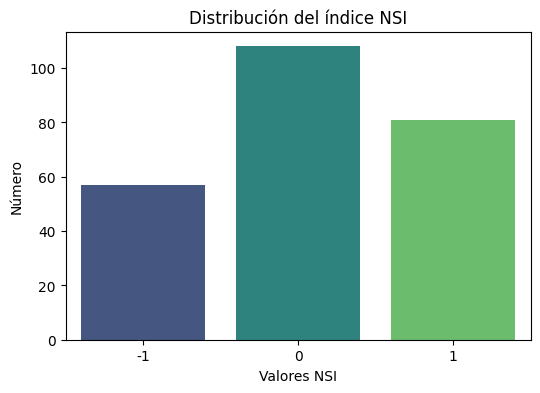

In [13]:
# Visualización de la distribución del índice NSI
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='NSI', data=stock_data, palette='viridis')
plt.title("Distribución del índice NSI")
plt.xlabel("Valores NSI")
plt.ylabel("Número")
plt.show()

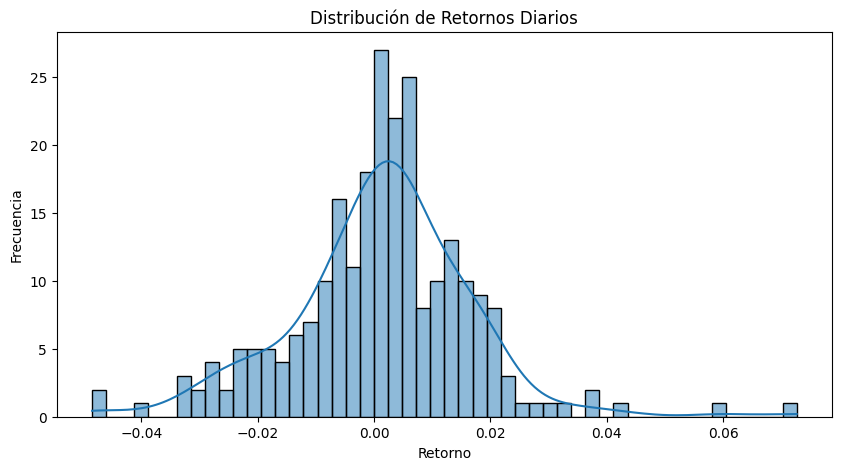

In [14]:
# Calcular retornos porcentuales diarios
stock_data['Return'] = stock_data['Close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(stock_data['Return'].dropna(), kde=True, bins=50)
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno")
plt.ylabel("Frecuencia")
plt.show()

In [15]:
# Entrenar modelos
model_price, scaler_price, X_val_price, y_val_price, X_test_price, y_test_price, history_price = train_lstm(stock_data, LOOK_BACK)
model_bert, scaler_bert, X_val_bert, y_val_bert, X_test_bert, y_test_bert, history_bert = train_lstm_bert(stock_data, news_sentiments_bert, LOOK_BACK)
model_finbert, scaler_finbert, X_val_finbert, y_val_finbert, X_test_finbert, y_test_finbert, history_finbert = train_lstm_finbert(stock_data, news_sentiments_finbert, LOOK_BACK)

# Guardar los modelos en la carpeta "models"
if not os.path.exists("models"):
    os.makedirs("models")
model_price.save("models/model_price.h5")
model_bert.save("models/model_bert.h5")
model_finbert.save("models/model_finbert.h5")
logging.info("Modelos guardados en la carpeta 'models'.")


INFO:root:Entrenando modelo LSTM (solo precios)...


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 6.8151 - val_loss: 5.6622 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.4152 - val_loss: 4.5845 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3627 - val_loss: 3.6894 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.4857 - val_loss: 2.9037 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7493 - val_loss: 2.2754 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1491 - val_loss: 1.7705 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6658 - val_loss: 1.3612 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2807 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9763 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━

INFO:root:Entrenando modelo LSTM + BERT...


Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - loss: 6.9925 - val_loss: 5.9267 - learning_rate: 0.0017
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7390 - val_loss: 4.9637 - learning_rate: 0.0017
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.8019 - val_loss: 4.1587 - learning_rate: 0.0017
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9930 - val_loss: 3.4311 - learning_rate: 0.0017
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.2765 - val_loss: 2.7678 - learning_rate: 0.0017
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6613 - val_loss: 2.2385 - learning_rate: 0.0017
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1503 - val_loss: 1.7926 - learning_rate: 0.0017
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7145 - val_loss: 1.4332 - learning_rate: 0.0017
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3607 - val_loss: 1.1180 - learning_rate: 0.0017
Epoch 10/150
3/3 ━━━━━━━━━━

INFO:root:Entrenando modelo LSTM + FinBERT...


Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 7.0137 - val_loss: 5.9784 - learning_rate: 0.0017
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.7524 - val_loss: 4.9797 - learning_rate: 0.0017
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.8271 - val_loss: 4.1607 - learning_rate: 0.0017
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.9995 - val_loss: 3.4530 - learning_rate: 0.0017
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.2945 - val_loss: 2.7832 - learning_rate: 0.0017
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.6717 - val_loss: 2.2487 - learning_rate: 0.0017
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1624 - val_loss: 1.8015 - learning_rate: 0.0017
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7246 - val_loss: 1.4429 - learning_rate: 0.0017
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3720 - val_loss: 1.1309 - learning_rate: 0.0017
Epoch 10/150
3/3 ━━━━━━━━━━

INFO:root:Modelos guardados en la carpeta 'models'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


INFO:root:[LSTM] RMSE=6.55, MAE=5.05, R²=0.75, MAPE=2.25%
INFO:root:[LSTM+BERT] RMSE=3.37, MAE=2.44, R²=0.93, MAPE=1.08%
INFO:root:[LSTM+FinBERT] RMSE=3.32, MAE=2.29, R²=0.93, MAPE=1.02%


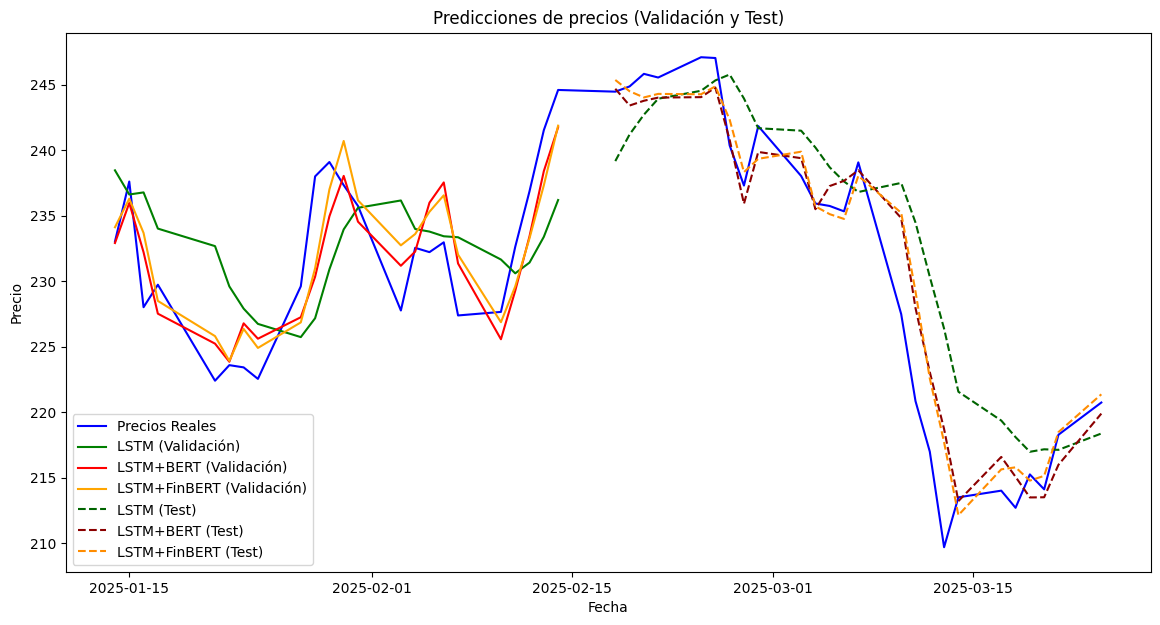

In [16]:
datasets = ((X_val_price, y_val_price, X_test_price, y_test_price),
            (X_val_bert, y_val_bert, X_test_bert, y_test_bert),
            (X_val_finbert, y_val_finbert, X_test_finbert, y_test_finbert))
models = (model_price, model_bert, model_finbert)
scalers = (scaler_price, scaler_bert, scaler_finbert)

# Mostrar gráfico comparativo de predicciones y métricas
plot_predictions(models, scalers, datasets, stock_data)

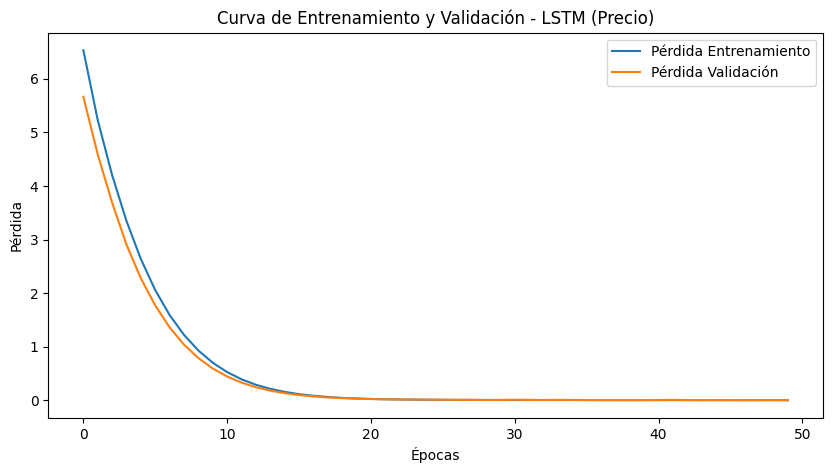

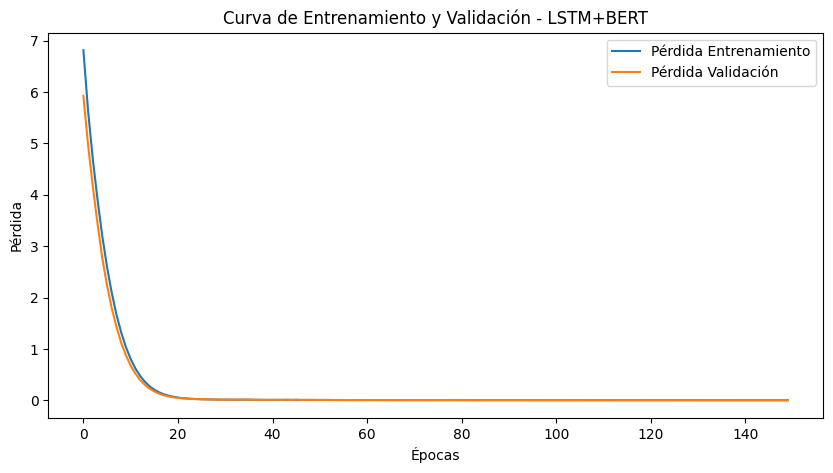

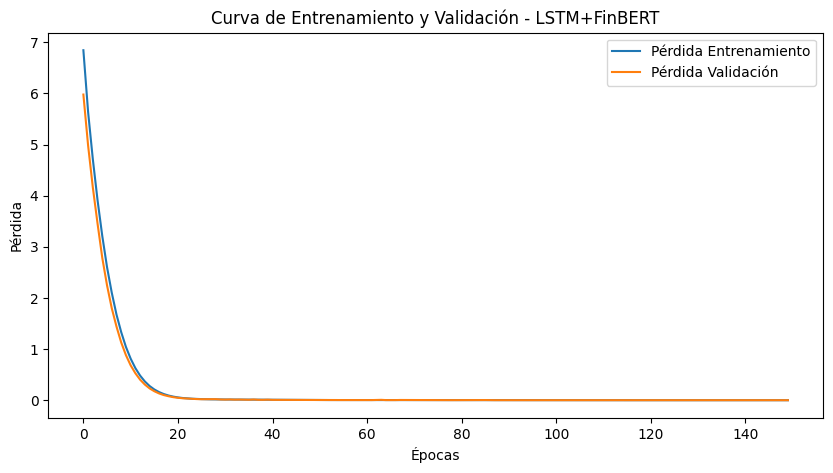

In [17]:
# Mostrar curvas de entrenamiento individual para cada modelo
plot_curves(
    [history_price, history_bert, history_finbert],
    ['LSTM (Precio)', 'LSTM+BERT', 'LSTM+FinBERT'])

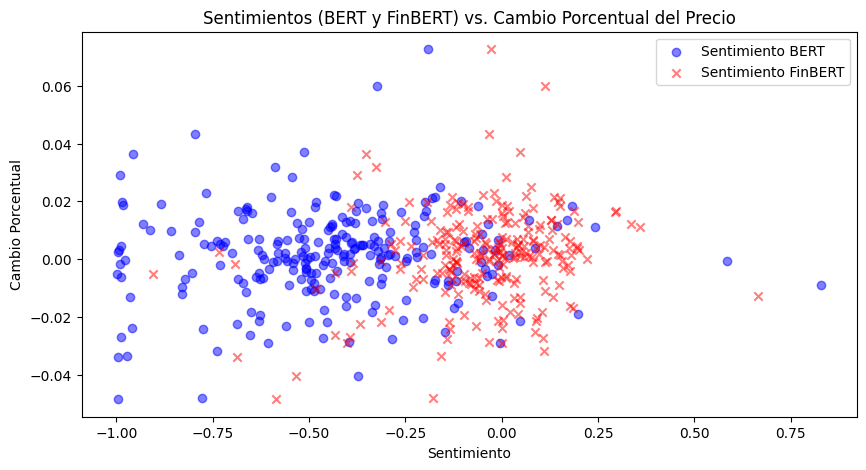

In [18]:
plt.figure(figsize=(10,5))
# Graficar sentimiento BERT
plt.scatter(stock_data['Sentiment_BERT'], stock_data['Close'].pct_change(), 
            alpha=0.5, label='Sentimiento BERT', color='blue')
# Graficar sentimiento FinBERT
plt.scatter(stock_data['Sentiment_FinBERT'], stock_data['Close'].pct_change(), 
            alpha=0.5, label='Sentimiento FinBERT', color='red', marker='x')

plt.title("Sentimientos (BERT y FinBERT) vs. Cambio Porcentual del Precio")
plt.xlabel("Sentimiento")
plt.ylabel("Cambio Porcentual")
plt.legend()
plt.show()
